In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
gamma = 5.0/3.0
B0 = 1.0
rho0 = 1.0
sheat_thickness = 1.0
p0 = B0**2 / 2.0 #カレントシート中央での圧力
beta_upstream = 0.2
VA = B0 / np.sqrt(rho0)
x_max = 100.0
y_max = 10.0
dx = sheat_thickness / 10.0
dy = dx
nx = int(x_max / dx)
ny = int(2.0 * y_max / dy)
dt = 0.0
CFL = 0.4
x = np.arange(0.0, x_max, dx)
y = np.arange(-y_max, y_max, dy)
X, Y = np.meshgrid(x, y)

U = np.zeros([8, x.shape[0], y.shape[0]])
rho_init = rho0 * (beta_upstream + np.cosh(Y / sheat_thickness)**(-2)).T
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = B0 * np.tanh(Y / sheat_thickness).T
By_init = 0.0
Bz_init = 0.0
# 擾乱を加える
position_x = 0.1 * x_max
p_init = p0 * (beta_upstream + np.cosh(Y / sheat_thickness)**(-2)).T
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

eta0 = 1.0 / 1000.0
eta1 = 1.0 / 60.0
eta = (eta0 + (eta1 - eta0) * np.cosh(np.sqrt((X - position_x)**2 + Y**2))**(-2)).T
S = sheat_thickness * VA / eta0

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

(-10.0, 10.0000000001)

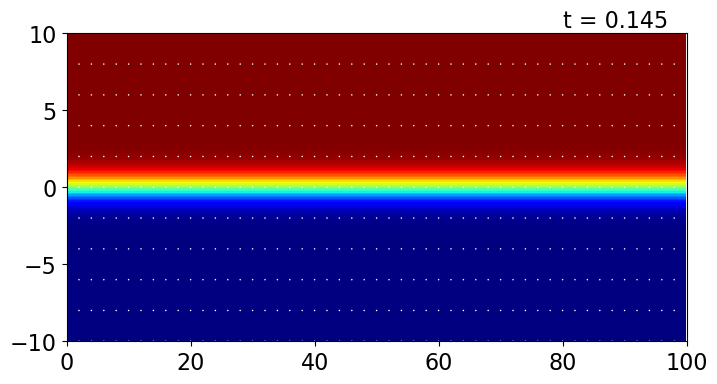

In [26]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

log = np.loadtxt("log_Petscheck.txt", delimiter=',')
dirname = "results"
step = 100
filename = f"{dirname}/Petscheck_{step}.bin"
with open(filename, 'rb') as f:
    U = np.fromfile(f, dtype=np.float64)
U = U.reshape(nx, ny, 8).T

rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure

contour = ax1.pcolormesh(X, Y, Bx / B0, vmin=-1.0, vmax=1.0, cmap='jet')
if step == 0:
    cbar = plt.colorbar(contour, ax=ax1)
    cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
quiver_interval = 20
ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
        u[::quiver_interval, ::quiver_interval], v[::quiver_interval, ::quiver_interval],
        scale=2.0, color='white')

ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(0.0, x_max+1e-10)
ax1.set_ylim(-y_max, y_max+1e-10)

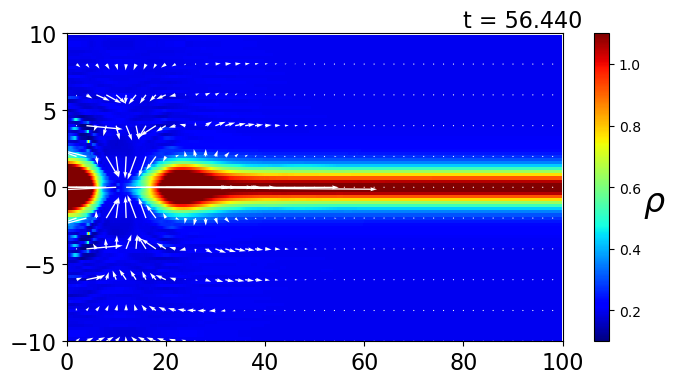

In [8]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

log = np.loadtxt("log_mr.txt", delimiter=',')
total_steps = int(log[-1][0])
interval = 100
for step in range(0, total_steps+interval, interval):
    ax1.clear()

    U = np.load(f"results_mr/U_{step}.npy")
    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 
    w = U[3, :, :] / rho 
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
    pT = p + magnetic_pressure

    contour = ax1.pcolormesh(X, Y, (rho).T, vmin=0.1, vmax=1.1, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.set_label(r"$\rho$", fontsize=24, rotation=0, labelpad=10)
    quiver_interval = 10
    ax1.quiver(X[::quiver_interval, ::quiver_interval], Y[::quiver_interval, ::quiver_interval], 
            u[::quiver_interval, ::quiver_interval].T, v[::quiver_interval, ::quiver_interval].T,
            scale=2.0, color='white')

    ax1.text(0.8, 1.02, f"t = {log[int(step/100)][1]:.3f}", transform=ax1.transAxes, fontsize=16)
    ax1.tick_params(labelsize=16)
    ax1.set_xlim(0.0, x_max+1e-10)
    ax1.set_ylim(-y_max, y_max+1e-10)

    fig.savefig(f"pictures_mr/{step}.png", dpi=200)


filename = "mr_rho.mp4"
img = cv2.imread(f'./pictures_mr/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures_mr/{step}.png')
    video.write(img)
video.release()